# Intro Task, Object Localization

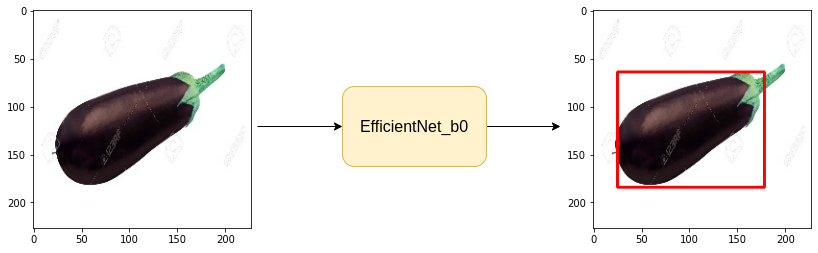

In [81]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-856qkcdv
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-856qkcdv
  Resolved https://github.com/albumentations-team/albumentations to commit 5eb2da80398ed7a25d0e67f97adb0f77e4206f22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [82]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [83]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [84]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [85]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE=140
LR=0.001
EPOCHS = 40

# MODEL_NAME='efficientnet_b0'
MODEL_NAME='resnet50'

NUM_COR= 4

In [86]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

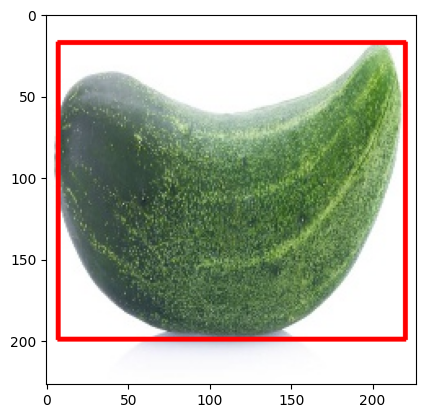

In [87]:
# selects a specific row (with index X) from a dataframe
row = df.iloc[18]
# reads the image from a file
img = cv2.imread(DATA_DIR + row.img_path)
# OpenCV loads images in BGR format by default, but many libraries (such as matplotlib) expect RGB format.
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# the top-left corner of the bounding box.
pt1 = (row.xmin, row.ymin)
# the bottom-right corner of the bounding box.
pt2 = (row.xmax, row.ymax)

# draws a rectangle (bounding box) on the image.
# (255, 0, 0): The color of the rectangle, specified as (R, G, B). This creates a red box.
# 2: The thickness of the rectangle's border in pixels.
bnd_box_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)

plt.imshow(bnd_box_img)


In [88]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)


# Augmentations

In [89]:
import albumentations as A

In [90]:
# A.Compose: This function combines multiple augmentation transforms into a single pipeline.
train_augs = A.Compose([
    # all images are of the same size before they go through the neural network.
    A.Resize(IMG_SIZE, IMG_SIZE),
    # 50% of the images will be flipped horizontally.
    A.HorizontalFlip(p=0.5),
    # applies a vertical flip to the image with a probability of 50%.
    A.VerticalFlip(p=0.5),
    # randomly rotate the image
    A.Rotate()
    # format='pascal_voc': bounding box using the top-left (xmin, ymin) and bottom-right (xmax, ymax) corners.
    # label_fields=['class_labels']: when bounding boxes are augmented, the associated class labels (in class_labels) are also adjusted accordingly.
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


In [91]:
valid_augs = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))


# Create Custom Dataset

In [92]:
# This class inherits from torch.utils.data.Dataset, which is the base class for all datasets in PyTorch. This allows the dataset to be used with PyTorch's DataLoader for batching and shuffling.
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self, df, augmentations=None):
    self.df = df
    self.augmentations = augmentations

  # returns the total number of samples in the dataset. It helps PyTorch know how many iterations the DataLoader should perform.
  def __len__(self):
    return len(self.df)

  # fetching a single item (image and bounding box) from the dataset.
  def __getitem__(self, idx):
    # Fetches the row at the given index (idx) from the DataFrame
    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax


    bbox = [[xmin, ymin, xmax, ymax]]
    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
      img = data['image']
      # Since only one bounding box is present, it retrieves the first bounding box with data['bboxes'][0]
      bbox = data['bboxes'][0]
    # Converts the image from a NumPy array (loaded with OpenCV) into a PyTorch tensor.
    # permute(2, 0, 1): This rearranges the dimensions of the image tensor from (height, width, channels) to (channels, height, width)
    # / 255.0: Normalizes the image values to the range [0, 1]
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0
    # Converts the bounding box coordinates into a PyTorch tensor.
    bbox = torch.Tensor(bbox)

    return img, bbox

In [93]:
# train_augs: augmentations defined using Albumentations that will be applied to the dataset.
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)


In [94]:
print(f"Total examples in the trainset : {len(trainset)}")
print(f"Total examples in the validset : {len(validset)}")


Total examples in the trainset : 148
Total examples in the validset : 38


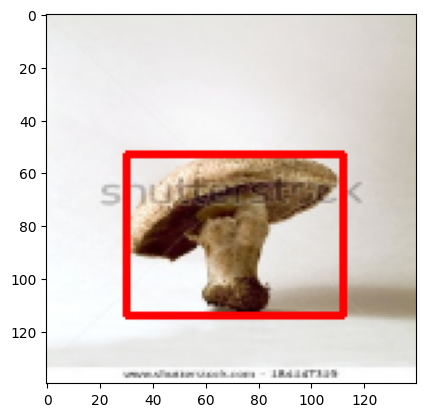

In [95]:
img, bbox = trainset[16]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [96]:
# A DataLoader is created for the training dataset (trainset), which batches the data into groups of BATCH_SIZE.
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
# shuffle=False ensures the data is not shuffled, since it’s important to maintain the order of validation examples for accurate evaluation.
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [97]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [98]:
for images, bboxes in trainloader:
    break

# torch.Size([16, 3, 140, 140]), which means:
# 16: The batch size (16 images in this batch).
# 3: The number of channels (RGB, so 3 channels).
# 140, 140: The height and width of each image (each image is 140x140 pixels).
print("Shape of one batch images : {}".format(images.shape))
# torch.Size([16, 4]), which means:
# 16: There are 16 bounding boxes, one for each image in the batch.
# 4: Each bounding box is represented by 4 coordinates (likely xmin, ymin, xmax, ymax), describing the top-left and bottom-right corners of the bounding box.
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [99]:
from torch import nn
import timm

In [100]:
class ObjLocModel(nn.Module):
  def __init__(self):
    # Calls the constructor of the parent class (nn.Module) to initialize the model.
    super(ObjLocModel, self).__init__()
    # The model is modified to output 4 values (num_classes=4), corresponding to the 4 bounding box coordinates (xmin, ymin, xmax, ymax).
    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    # The input images are passed through the backbone network (pre-trained model), and it returns predicted bounding box coordinates.
      bboxes = self.backbone(images)
      # If gt_bboxes (ground truth bounding boxes) are provided, it means the model is in training mode.
      if gt_bboxes != None:
        # Mean Squared Error (MSE)
          loss = nn.MSELoss()(bboxes, gt_bboxes)
          return bboxes, loss

      return bboxes


In [101]:
model = ObjLocModel()
model.to(DEVICE)


ObjLocModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05,

In [102]:
# A random input tensor is generated to simulate a single image with 3 channels (RGB) and a size of 140x140 pixels.
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
# The output is a tensor of size (1, 4), where 1 is the batch size (one image), and 4 represents the predicted bounding box coordinates (xmin, ymin, xmax, ymax)
model(random_img).shape


torch.Size([1, 4])

# Create Train and Eval Function

In [103]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train()  # Dropout ON
  for data in tqdm(dataloader):
    images, gt_bboxes = data
    # Moves the images and gt_bboxes tensors to the specified device (e.g., GPU or CPU) to ensure the model and data are on the same device for training.
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
    # The input images are passed through the model.
    bboxes, loss = model(images, gt_bboxes)
    # clears the gradients of all optimized parameters (weights). Gradients accumulate by default in PyTorch, so it's important to zero them out before each backpropagation step to avoid incorrect gradient accumulation from previous batches.
    optimizer.zero_grad()
    # Performs backpropagation by calculating the gradients of the loss with respect to the model’s parameters.
    loss.backward()
    # Updates the model's parameters based on the gradients that were computed during backpropagation.
    optimizer.step()
    total_loss += loss.item()
  return total_loss / len(dataloader)


In [104]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval()  # Dropout OFF
  # backpropagation is not required when evaluating the model.
  with torch.no_grad():
    for data in tqdm(dataloader):
      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
      bboxes, loss = model(images, gt_bboxes)
      total_loss += loss.item()
  return total_loss / len(dataloader)



#Training Loop

In [105]:
# model.parameters(): This passes the model’s parameters (weights) to the optimizer so that it can update them.
# lr=LR: The learning rate (LR) is set as a variable, which controls the step size at each iteration of the optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [106]:
train_loss_values = []
valid_loss_values = []
# It is set to infinity (np.Inf) initially because any loss calculated during the first epoch will be lower than this value.
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)
  if valid_loss < best_valid_loss:
    # model.state_dict() saves the model’s learned parameters (weights) in a PyTorch dictionary format.
    torch.save(model.state_dict(), 'best_model.pt')
    print("WEIGHTS ARE SAVED")
    best_valid_loss = valid_loss
  train_loss_values.append(train_loss)
  valid_loss_values.append(valid_loss)
  print(f"Epoch : {i + 1} train loss : {train_loss} valid loss : {valid_loss}")


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 1 train loss : 7534.730419921875 valid loss : 6924.6689453125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 2 train loss : 7036.51591796875 valid loss : 5340.025716145833


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 3 train loss : 6092.96826171875 valid loss : 3195.1675618489585


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 4 train loss : 4796.665454101562 valid loss : 2502.1494954427085


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 train loss : 3338.182666015625 valid loss : 2671.620646158854


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 6 train loss : 1754.2781005859374 valid loss : 2233.2396647135415


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 7 train loss : 579.6019805908203 valid loss : 1033.79638671875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 8 train loss : 243.35345611572265 valid loss : 347.4741923014323


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 9 train loss : 194.5489288330078 valid loss : 357.33437093098956


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss : 207.95024871826172 valid loss : 368.70775349934894


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 11 train loss : 219.91434326171876 valid loss : 291.32753499348956


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 12 train loss : 200.75551071166993 valid loss : 255.85027058919272


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 13 train loss : 187.9845748901367 valid loss : 212.9638468424479


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 14 train loss : 178.80519256591796 valid loss : 240.94380696614584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 15 train loss : 159.54387817382812 valid loss : 203.40925089518228


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 16 train loss : 158.47097549438476 valid loss : 199.31006368001303


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 17 train loss : 161.60531768798828 valid loss : 187.76980590820312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 18 train loss : 156.203515625 valid loss : 174.32701110839844


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 19 train loss : 126.35041465759278 valid loss : 173.63202412923178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 20 train loss : 142.19127044677734 valid loss : 158.13158416748047


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss : 121.46062240600585 valid loss : 222.37024943033853


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 22 train loss : 129.79557342529296 valid loss : 154.24170430501303


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 23 train loss : 119.57233810424805 valid loss : 131.10077921549478


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 24 train loss : 98.0639404296875 valid loss : 140.60015614827475


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss : 101.4709716796875 valid loss : 147.84555053710938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 26 train loss : 109.37401542663574 valid loss : 125.72666931152344


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 27 train loss : 99.04438934326171 valid loss : 116.09453837076823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss : 96.62501068115235 valid loss : 130.26990763346353


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 29 train loss : 79.1006462097168 valid loss : 122.19844818115234


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss : 84.31790199279786 valid loss : 128.5651652018229


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 31 train loss : 85.92684745788574 valid loss : 105.11978658040364


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss : 82.39832382202148 valid loss : 131.50697326660156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 33 train loss : 85.7333366394043 valid loss : 102.89446767171223


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss : 85.59862060546875 valid loss : 103.74906412760417


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 35 train loss : 78.35507736206054 valid loss : 102.79704284667969


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss : 76.4811164855957 valid loss : 120.00132242838542


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss : 65.41962394714355 valid loss : 123.36097208658855


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss : 87.50859756469727 valid loss : 111.17211405436198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
Epoch : 39 train loss : 76.32053184509277 valid loss : 95.99505106608073


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss : 84.45613403320313 valid loss : 108.46722157796223


#Inference

In [107]:
import utils

<ipython-input-108-26ff9ddc6927>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


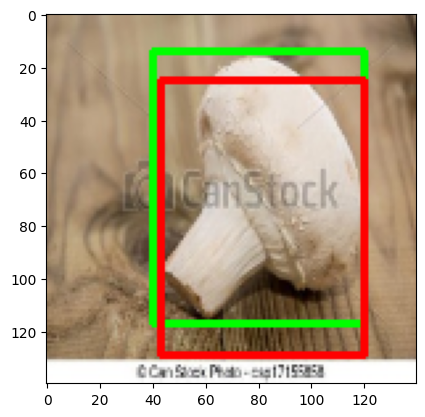

In [108]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# This context disables gradient calculation during inference, which reduces memory usage and speeds up the process, as gradients are not needed when making predictions.
with torch.no_grad():
  image, gt_bbox = validset[23]  #(c, h, w)
  # This adds an additional dimension to the image tensor to represent the batch size, converting it from a shape of (channels, height, width) to (batch_size, channels, height, width).
  image = image.unsqueeze(0).to(DEVICE)  #(bs, c, h, w)
  out_bbox = model(image)
  # This is a utility function that plots the image with both the ground truth bounding box (gt_bbox) and the predicted bounding box (out_bbox) for visual comparison.
  utils.compare_plots(image, gt_bbox, out_bbox)


# Evaluate Model

## Intersection over Union (IoU)


The most fundamental metric for object detection is Intersection over Union (IoU). It measures how much overlap there is between the predicted bounding box and the ground truth bounding box.

IoU = Intersection Area/ Union Area

In [109]:
def calculate_iou(pred_box, gt_box):
    # Unpack the boxes
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_box
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = gt_box

    # Determine the coordinates of the intersection rectangle
    inter_xmin = max(pred_xmin, gt_xmin)
    inter_ymin = max(pred_ymin, gt_ymin)
    inter_xmax = min(pred_xmax, gt_xmax)
    inter_ymax = min(pred_ymax, gt_ymax)

    # Compute the area of intersection
    inter_area = max(0, inter_xmax - inter_xmin) * max(0, inter_ymax - inter_ymin)

    # Compute the area of both bounding boxes
    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    gt_area = (gt_xmax - gt_xmin) * (gt_ymax - gt_ymin)

    # Compute the union area
    union_area = pred_area + gt_area - inter_area

    # Compute the IoU
    iou = inter_area / union_area if union_area != 0 else 0

    return iou


## Mean IoU

In [110]:
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    total_iou = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, gt_bboxes in dataloader:
            images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
            pred_bboxes = model(images)

            # Calculate IoU for each sample
            for i in range(len(images)):
                # Move data from GPU memory to CPU memory for use in subsequent calculations.
                iou = calculate_iou(pred_bboxes[i].cpu().numpy(), gt_bboxes[i].cpu().numpy())
                total_iou += iou
                total_samples += 1

    # Calculate mean IoU
    mean_iou = total_iou / total_samples if total_samples > 0 else 0
    print(f'Mean IoU: {mean_iou:.4f}')
    return mean_iou


In [111]:
mean_iou=evaluate_model(model,validloader)

Mean IoU: 0.7190


## Accuracy

set an IoU threshold, such as 0.5 or 0.75, and calculate the percentage of predictions that meet or exceed this threshold. This can give you a more direct sense of how often the model is making "good" predictions.

In [118]:
def evaluate_accuracy(model, dataloader, iou_threshold=0.5):
    model.eval()  # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0
    iou_values_list = []
    with torch.no_grad():
      for images, gt_bboxes in dataloader:
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)
        pred_bboxes = model(images)

        # Calculate IoU and check if it meets the threshold
        for i in range(len(images)):
          iou = calculate_iou(pred_bboxes[i].cpu().numpy(), gt_bboxes[i].cpu().numpy())
          if iou >= iou_threshold:
              correct_predictions += 1
          total_samples += 1
          iou_values_list.append(iou)

    # Calculate accuracy
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    print(f'Accuracy at IoU >= {iou_threshold}: {accuracy:.4f}')
    return accuracy, iou_values_list


In [119]:
iou_threshold = 0.6
accuracy,iou_values_list= evaluate_accuracy(model,validloader, iou_threshold)

Accuracy at IoU >= 0.6: 0.8421


In [120]:
iou_values_list

[0.57430047,
 0.7244508,
 0.753384,
 0.8185898,
 0.7574671,
 0.7684552,
 0.8368076,
 0.82203907,
 0.6392144,
 0.43198326,
 0.3072767,
 0.85890216,
 0.8044227,
 0.8023478,
 0.699866,
 0.69570786,
 0.81335753,
 0.7095357,
 0.4358587,
 0.803715,
 0.72810656,
 0.6642011,
 0.75531936,
 0.746499,
 0.6241669,
 0.86949086,
 0.7449977,
 0.70423067,
 0.9132763,
 0.6756947,
 0.6208638,
 0.4489516,
 0.7068841,
 0.69364554,
 0.7977775,
 0.8564962,
 0.5352108,
 0.6802137]

# Data Visualize

## Visualizing Bounding Boxes on Images
You can visualize the model's predictions by drawing the ground truth and predicted bounding boxes on the images. This gives an immediate sense of how well the model is localizing objects.

In computer vision, bounding boxes are typically defined by two diagonal corner points: the top-left corner and the bottom-right corner.

###  Image Coordinate System
The coordinate system used in image processing is different from the Cartesian coordinate system. In an image, the origin ((0, 0)) is usually located at the top-left corner, and coordinates increase:

* X-axis (horizontal) values increase from left to right.
* Y-axis (vertical) values increase from top to bottom.

### gt_bbox Definition

Let’s assume gt_bbox = [xmin, ymin, xmax, ymax], which defines the bounding box as follows:

* gt_bbox[0] = xmin: x-coordinate of the **top-left corner**.
* gt_bbox[1] = ymin: y-coordinate of the **top-left corner**.
* gt_bbox[2] = xmax: x-coordinate of the **bottom-right corner**.
* gt_bbox[3] = ymax: y-coordinate of the **bottom-right corner**.

In [114]:
import matplotlib.pyplot as plt
import cv2

def visualize_bboxes(image, gt_bbox, pred_bbox):
    """
    Visualizes ground truth and predicted bounding boxes on the image.
    Green -> Ground Truth
    Red -> Predicted Bounding Box
    """
    # Convert tensor to numpy array if needed
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    # Convert the image to uint8 (ensure proper type for display)
    image = image.astype(np.uint8)

    # Convert the bounding boxes from tensor/array to integers
    gt_bbox = [int(x) for x in gt_bbox]  # Ground truth
    pred_bbox = pred_bbox.squeeze()  # Remove extra dimensions, if any
    pred_bbox = [int(x) for x in pred_bbox]  # Predicted

    # Draw the ground truth bounding box in green
    # (gt_bbox[0], gt_bbox[1]): the top-left corner
    # (gt_bbox[2], gt_bbox[3]): bottom-right corner
    image = cv2.rectangle(image, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), (0, 255, 0), 2)

    # Draw the predicted bounding box in red
    image = cv2.rectangle(image, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (255, 0, 0), 2)

    # Display the image with both bounding boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()



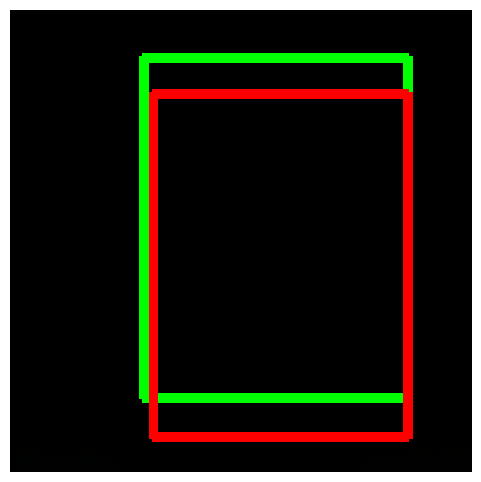

In [115]:
with torch.no_grad():
    image, gt_bbox = validset[23]
    image = image.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device
    pred_bbox = model(image)  # Get predicted bounding box

    # Visualize the bounding boxes
    visualize_bboxes(image.squeeze().cpu(), gt_bbox, pred_bbox.cpu().numpy())



## Plotting IoU over Epochs

You can track the IoU across each image during validloader

In [122]:
import matplotlib.pyplot as plt

def plot_iou(iou_values):
    """
    Plots the IoU values across each image.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(iou_values, label="IoU", marker='o', color='b')
    plt.xlabel('image')
    plt.ylabel('IoU')
    plt.title('IoU over each image')
    plt.legend()
    plt.grid(True)
    plt.show()



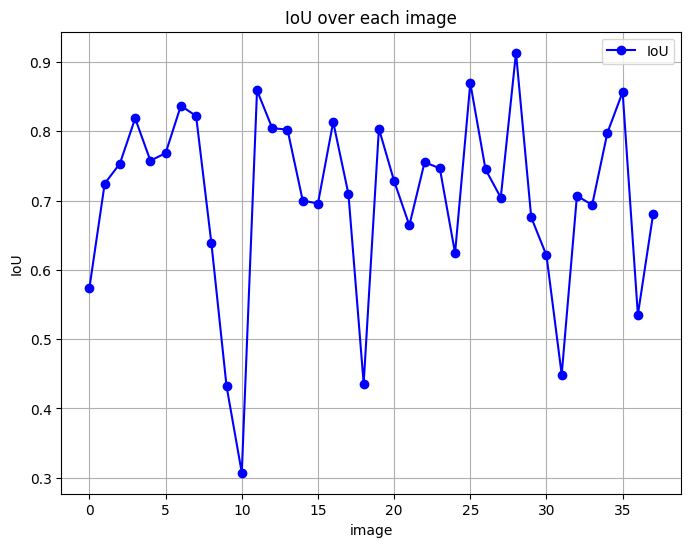

In [123]:
plot_iou(iou_values_list)


In [124]:
def plot_loss(train_loss_values, valid_loss_values):
    """
    Plots the training and validation loss over epochs.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_values, label="Training Loss", marker='o', color='b')
    plt.plot(valid_loss_values, label="Validation Loss", marker='o', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


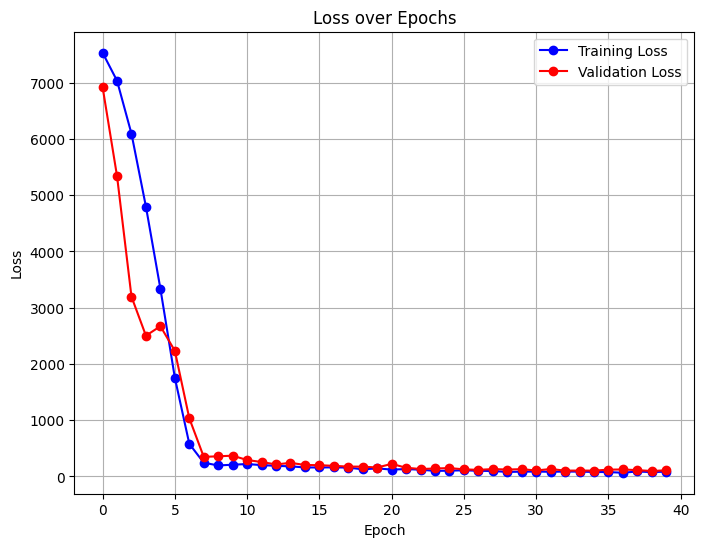

In [125]:

plot_loss(train_loss_values, valid_loss_values)


## Confusion Matrix

You can visualize how well the model predicts bounding boxes by using a confusion matrix that tracks how many predictions are above a certain IoU threshold (e.g., IoU >= 0.5) and how many are not.

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def calculate_confusion_matrix(iou_values, threshold=0.5):
    """
    Calculates a confusion matrix based on IoU threshold.
    """
    y_true = [1] * len(iou_values)  # Ground truth, assume all are positives
    y_pred = [1 if iou >= threshold else 0 for iou in iou_values]  # Predicted as positive if IoU >= threshold

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.show()


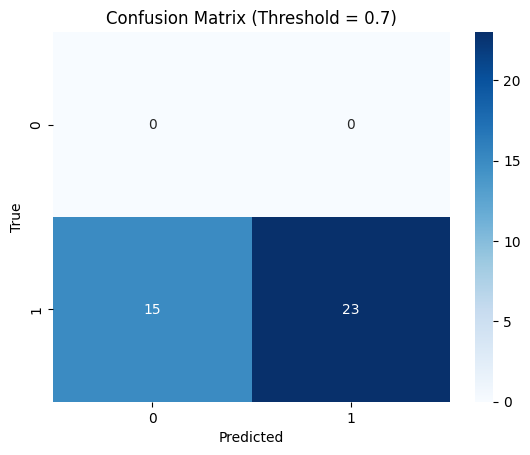

In [128]:
calculate_confusion_matrix(iou_values_list, threshold=0.7)

## Comparing Multiple Images

You can create a plot that visualizes multiple validation images, each with their ground truth and predicted bounding boxes. This can provide a comprehensive view of how well the model is performing across different examples.

In [131]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_multiple_images(validset, model, num_images=5):
    """
    Visualizes ground truth and predicted bounding boxes on multiple images.
    Green -> Ground Truth
    Red -> Predicted Bounding Box
    """
    plt.figure(figsize=(15, 10))

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradients needed during evaluation
        for i in range(num_images):
            image, gt_bbox = validset[i]  # Fetch image and ground truth bbox
            image = image.unsqueeze(0).to(DEVICE)  # Add batch dimension and move to device
            pred_bbox = model(image).cpu().numpy()  # Predict bounding box and move to CPU

            # Convert image for plotting
            image = image.squeeze().cpu().permute(1, 2, 0).numpy().astype(np.uint8)  # Convert to HWC format

            # Ground Truth Bbox -> Convert to int for cv2.rectangle
            gt_bbox = [int(x) for x in gt_bbox]

            # Predicted Bbox -> Squeeze and convert to int for cv2.rectangle
            pred_bbox = pred_bbox.squeeze()  # Remove extra dimensions
            pred_bbox = [int(x) for x in pred_bbox]

            # Draw the ground truth bounding box in green
            image = cv2.rectangle(image, (gt_bbox[0], gt_bbox[1]), (gt_bbox[2], gt_bbox[3]), (0, 255, 0), 2)  # Green

            # Draw the predicted bounding box in red
            image = cv2.rectangle(image, (pred_bbox[0], pred_bbox[1]), (pred_bbox[2], pred_bbox[3]), (255, 0, 0), 2)  # Red

            # Plot each image with bounding boxes
            plt.subplot(1, num_images, i+1)
            plt.imshow(image)
            plt.axis('off')

    plt.show()



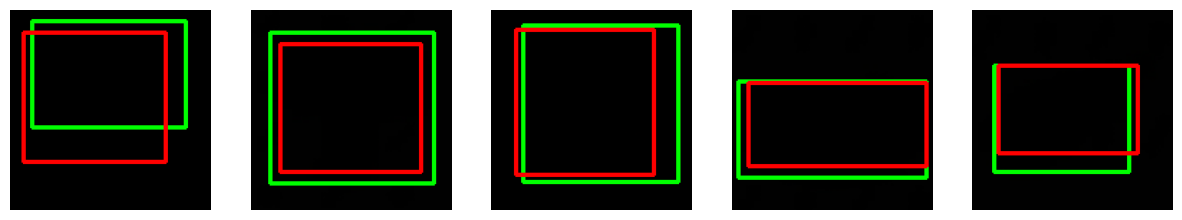

In [132]:
visualize_multiple_images(validset, model, num_images=5)
